In [1]:
from descargar_tickets import *
from dateutil.relativedelta import relativedelta
from OptimizarCarteraDinamico import minimizar_riesgo_dinamico
from OptimizarCartera import minimizar_riesgo
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_tickers_crudo = descargar_sp500_mensual(2010,2025, guardar_csv=False)
# Descargo spy
df_spy = descargar_spy(2010,2025)
df_spy['Date'] = pd.to_datetime(df_spy['Date'])
df_spy = df_spy.sort_values(['Ticker', 'Date'])

# Calcular retornos logarítmicos mensuales
df_spy['Return'] = df_spy.groupby('Ticker')['Close'].transform(lambda x: np.log(x / x.shift(1)))
df_spy = df_spy.dropna(subset=['Return'])



2 Failed downloads:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1mo 2010-01-01 -> 2025-12-31)')
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


In [19]:
df_tickers_crudo['Date'] = pd.to_datetime(df_tickers_crudo['Date'])
# Ordenar
df_tickers_crudo = df_tickers_crudo.sort_values(['Ticker', 'Date'])

# Calcular retornos logarítmicos mensuales
df_tickers_crudo['Return'] = df_tickers_crudo.groupby('Ticker')['Close'].transform(lambda x: np.log(x / x.shift(1)))
df_tickers_crudo = df_tickers_crudo.dropna(subset=['Return'])


In [20]:
rebalance_freq = 1  # meses
window = 100         # meses de historial para estimar rendimientos y covarianzas

all_dates = sorted(df_tickers_crudo['Date'].unique())
start_date = pd.Timestamp("2025-01-01")

# Filtrar fechas desde 2024 y seleccionar cada rebalance_freq meses
dates = []
current_date = None
for d in all_dates:
    if d >= start_date:
        if current_date is None:
            # Primera fecha de rebalanceo
            dates.append(d)
            current_date = d
        elif d >= current_date + relativedelta(months=rebalance_freq):
            # Han pasado al menos rebalance_freq meses
            dates.append(d)
            current_date = d

print(f"Fechas de rebalanceo ({len(dates)}): {[d.date() for d in dates[:5]]}...")

# Dataframe para guardar resultados
results = []
benchmark_results = []
portfolio_weights = []  # NUEVO: para guardar los pesos

Fechas de rebalanceo (11): [datetime.date(2025, 1, 1), datetime.date(2025, 2, 1), datetime.date(2025, 3, 1), datetime.date(2025, 4, 1), datetime.date(2025, 5, 1)]...


In [21]:

for d in dates:
    print("Rebalanceo en:", d.date())
    # Ventana de entrenamiento (por ejemplo, últimos 24 meses)
    start_window = d - relativedelta(months=window)
    df_window = df_tickers_crudo[(df_tickers_crudo['Date'] >= start_window) & (df_tickers_crudo['Date'] < d)]
    
    # Validacion nro de observaciones por ticker
    ticker_counts = df_window.groupby('Ticker').size()
    min_observations = 12  # Al menos 12 meses de datos
    valid_tickers = ticker_counts[ticker_counts >= min_observations].index
    df_window = df_window[df_window['Ticker'].isin(valid_tickers)]

    # Calcular rendimientos esperados y covarianza
    mean_return = df_window.groupby('Ticker')['Return'].mean()
    momentum = df_window.groupby('Ticker').apply(lambda x: x.sort_values('Date').tail(3)['Return'].mean())
    mu = 0.5*mean_return + 0.5*momentum
    if mu.isna().any():
        print(f"  ⚠ Warning: NaN en mu para {d.date()}")
        print(f"     Tickers con NaN: {mu[mu.isna()].index.tolist()}")
        mu = mu.fillna(mu.median())  # Rellenar con mediana
    Sigma = df_window.pivot(index='Date', columns='Ticker', values='Return').cov()
    sigma_i = np.sqrt(np.diag(Sigma))       # desviaciones estándar
    T = len(df_window['Date'].unique())      # tamaño muestra (p. ej. meses)
    delta = 1.96 * sigma_i / np.sqrt(T) 
    
    
        # VALIDACIÓN 5: Verificar que todos los inputs son finitos
    # ========================================================================
    if not np.isfinite(mu.values).all():
        print(f"  ⚠ Warning: Valores no finitos en mu")
        mu = mu.replace([np.inf, -np.inf], np.nan).fillna(mu.median())
    
    if not np.isfinite(sigma_i).all():
        print(f"  ⚠ Warning: Valores no finitos en sigma_i")
        sigma_i = np.nan_to_num(sigma_i, nan=sigma_i[np.isfinite(sigma_i)].mean())
    
    if not np.isfinite(delta).all():
        print(f"  ⚠ Warning: Valores no finitos en delta")
        delta = np.nan_to_num(delta, nan=delta[np.isfinite(delta)].mean())
    
    
    
    # Datos para el modelo
    mu_dict = mu.to_dict()
    Sigma_dict = Sigma.stack().to_dict()  # crea un dict con keys (i, j)
    delta_dict = pd.Series(delta, index=Sigma.index).to_dict()
    
    
    # Chequear que no haya nans en mu, Sigma, delta y reemplazar por promedios razonables
    mu_dict = {k: (v if not pd.isna(v) else mean_return.mean()) for k, v in mu_dict.items()}
    delta_dict = {k: (v if not pd.isna(v) else delta.mean()) for k, v in delta_dict.items()}
    Sigma_keys = list(Sigma_dict.keys())
    for key in Sigma_keys:
        if pd.isna(Sigma_dict[key]):
            i, j = key
            Sigma_dict[key] = sigma_i.mean() ** 2 if i == j else 0.0
    
    
    # --- Modelo de optimización (ejemplo simple: media-varianza clásica) ---
    
    # Si es el primer rebalanceo, usar MVO clásico
    if d == dates[0]:
        w_opt = minimizar_riesgo(mu_dict, Sigma_dict, delta_dict, aversion=2)
    else:
        # Busco los pesos anteriores y utiliz el modelo dinámico
        w_opt = minimizar_riesgo_dinamico(mu_dict, Sigma_dict, delta_dict, pesos_anteriores, aversion=2)
    w_opt = pd.Series(w_opt).reindex(Sigma.columns).fillna(0)
    pesos_anteriores = w_opt.copy()
    weights_dict = {'Date': d}
    weights_dict.update(w_opt.to_dict())
    
    portfolio_weights.append(weights_dict)

    # Retornos siguientes 3 meses
    next_period = df_tickers_crudo[
        (df_tickers_crudo['Date'] >= d) &
        (df_tickers_crudo['Date'] < d + relativedelta(months=rebalance_freq))
    ]

    if next_period.empty:
        continue
    next_returns = next_period.pivot(index='Date', columns='Ticker', values='Return').fillna(0)
    common_tickers = next_returns.columns.intersection(w_opt.index)
    next_returns = next_returns[common_tickers]
    w_opt = w_opt[common_tickers]
    
    if w_opt.sum() == 0:
        continue
    w_opt = w_opt / w_opt.sum()  # Renormalize to sum to 1

    # Calcular rendimiento del portafolio
    port_ret = (next_returns.values @ w_opt.values).sum()
    results.append({'Date': d, 'Portfolio_Return': port_ret})

    mask_spy = (df_spy['Date'] >= d) & (df_spy['Date'] < d + relativedelta(months=rebalance_freq))
    spy_returns_period = df_spy.loc[mask_spy, 'Return']
    bench_ret = spy_returns_period.sum()
    benchmark_results.append({'Date': d, 'Benchmark_Return': bench_ret})
    
    print(f"  Portfolio: {port_ret:.4f}, Benchmark: {bench_ret:.4f}")



Rebalanceo en: 2025-01-01
  Portfolio: 0.0624, Benchmark: 0.0299
Rebalanceo en: 2025-02-01
  Portfolio: -0.1004, Benchmark: -0.0128
Rebalanceo en: 2025-03-01
  Portfolio: -0.1296, Benchmark: -0.0603
Rebalanceo en: 2025-04-01
  Portfolio: 0.0698, Benchmark: -0.0057
Rebalanceo en: 2025-05-01
  Portfolio: 0.0209, Benchmark: 0.0609
Rebalanceo en: 2025-06-01
  Portfolio: 0.0507, Benchmark: 0.0472
Rebalanceo en: 2025-07-01
  Portfolio: 0.0395, Benchmark: 0.0257
Rebalanceo en: 2025-08-01
  Portfolio: -0.0635, Benchmark: 0.0203
Rebalanceo en: 2025-09-01
  Portfolio: 0.0933, Benchmark: 0.0322
Rebalanceo en: 2025-10-01
  Portfolio: 0.0292, Benchmark: 0.0263
Rebalanceo en: 2025-11-01
  Portfolio: -0.0336, Benchmark: -0.0122


In [22]:
df_results = pd.DataFrame(results).sort_values('Date')
benchmark = pd.DataFrame(benchmark_results).sort_values('Date')

# Merge
df_plot = pd.merge(df_results, benchmark, on='Date', how='inner')

# Retornos acumulados (suma de logs)
df_plot['Cum_Portfolio'] = df_plot['Portfolio_Return'].cumsum()
df_plot['Cum_Benchmark'] = df_plot['Benchmark_Return'].cumsum()

# Convertir a retornos porcentuales para mejor interpretación
df_plot['Cum_Portfolio_Pct'] = np.exp(df_plot['Cum_Portfolio']) - 1
df_plot['Cum_Benchmark_Pct'] = np.exp(df_plot['Cum_Benchmark']) - 1

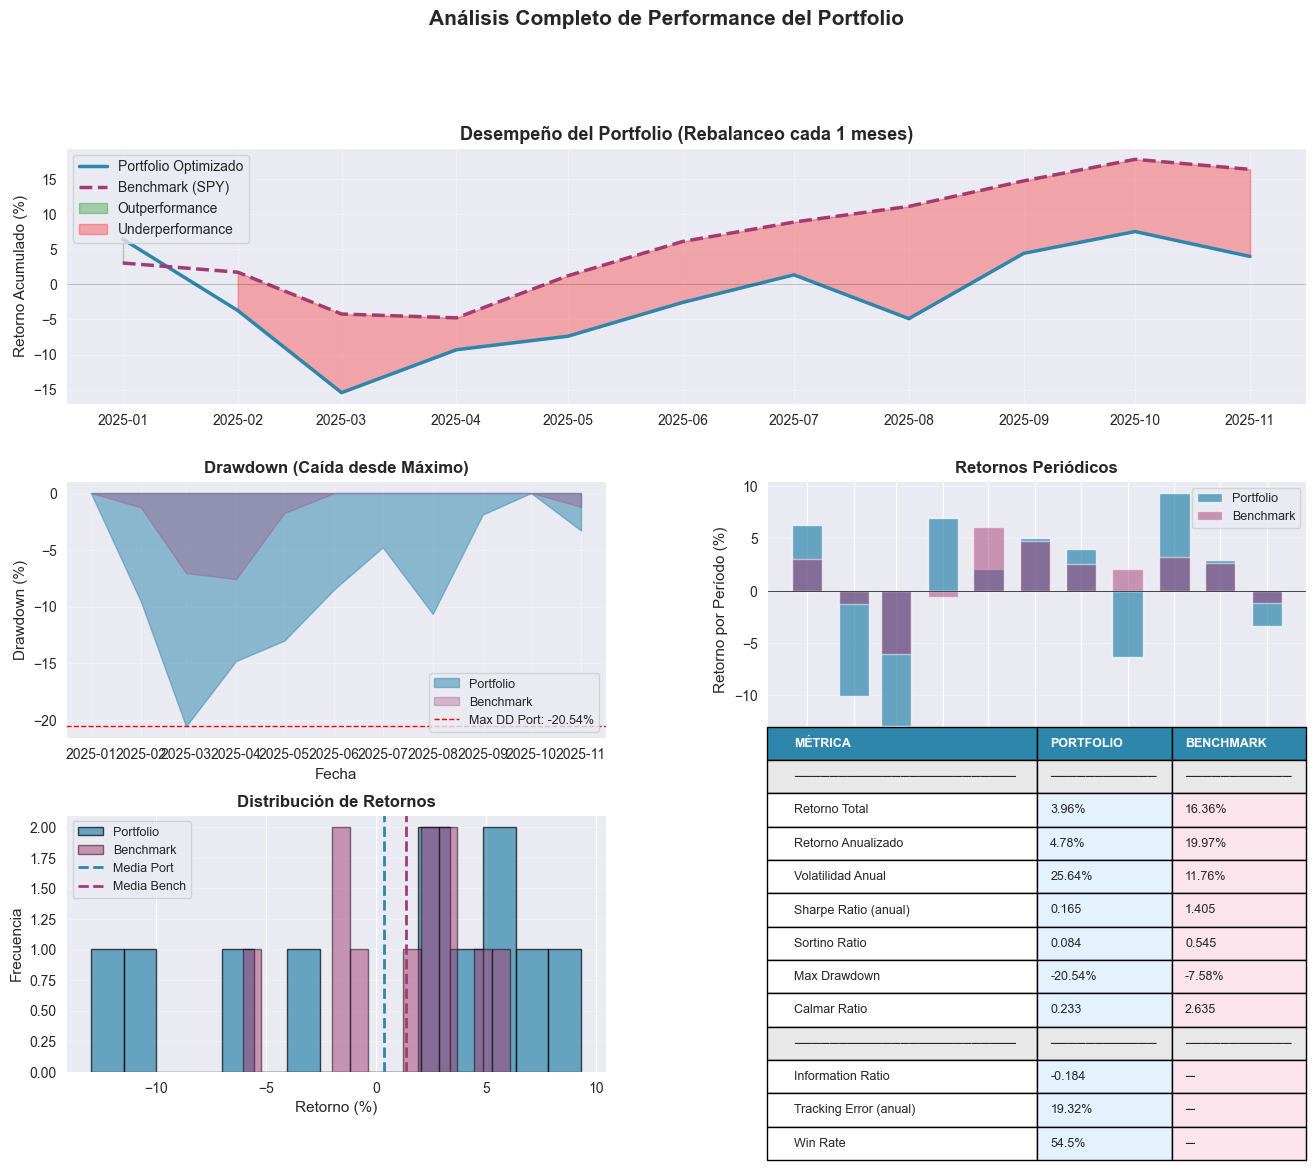


REPORTE COMPLETO DE ANÁLISIS DE PORTFOLIO
Período: 2025-01-01 a 2025-11-01 (0.83 años)
Número de rebalanceos: 11
Frecuencia de rebalanceo: 1 meses

--------------------------------------------------------------------------------
1. RETORNOS
--------------------------------------------------------------------------------
                                     Portfolio       Benchmark      Diferencia
Total                                   3.96%         16.36%        -12.40%
Anualizado                              4.78%         19.97%        -15.19%
Por período (promedio)                  0.35%          1.38%

--------------------------------------------------------------------------------
2. RIESGO
--------------------------------------------------------------------------------
Volatilidad Anualizada                 25.64%         11.76%
Maximum Drawdown                      -20.54%         -7.58%
  - Fecha del pico             0
  - Fecha del valle            2
Tracking Error (anual)  

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ============================================================================
# FUNCIONES DE MÉTRICAS
# ============================================================================

def calculate_max_drawdown(cumulative_returns):
    """
    Calcula el Maximum Drawdown (máxima caída desde el pico más alto)
    
    Returns:
        max_dd: Maximum drawdown (valor negativo)
        peak_date: Fecha del pico antes de la mayor caída
        valley_date: Fecha del valle (punto más bajo)
    """
    cumulative_wealth = 1 + cumulative_returns
    running_max = cumulative_wealth.expanding().max()
    drawdown = (cumulative_wealth - running_max) / running_max
    
    max_dd = drawdown.min()
    valley_idx = drawdown.idxmin()
    peak_idx = cumulative_wealth[:valley_idx].idxmax()
    
    return max_dd, peak_idx, valley_idx

def calculate_calmar_ratio(total_return, max_drawdown, years):
    """
    Calmar Ratio = Retorno Anualizado / |Maximum Drawdown|
    Mide retorno ajustado por riesgo de caídas extremas
    """
    annualized_return = (1 + total_return) ** (1/years) - 1
    if max_drawdown == 0:
        return np.inf
    return annualized_return / abs(max_drawdown)

def calculate_sortino_ratio(returns, rf=0):
    """
    Sortino Ratio = (Retorno medio - rf) / Desviación de retornos negativos
    Similar a Sharpe pero solo penaliza volatilidad a la baja
    """
    excess_return = returns.mean() - rf
    downside_returns = returns[returns < rf]
    if len(downside_returns) == 0 or downside_returns.std() == 0:
        return np.inf
    downside_std = downside_returns.std()
    return excess_return / downside_std

def calculate_information_ratio(portfolio_returns, benchmark_returns):
    """
    Information Ratio = Exceso de retorno medio / Tracking Error
    Mide consistencia del outperformance vs benchmark
    """
    excess_returns = portfolio_returns - benchmark_returns
    tracking_error = excess_returns.std()
    if tracking_error == 0:
        return np.inf
    return excess_returns.mean() / tracking_error

def calculate_win_rate(portfolio_returns, benchmark_returns):
    """
    % de períodos en que el portfolio superó al benchmark
    """
    wins = (portfolio_returns > benchmark_returns).sum()
    total = len(portfolio_returns)
    return wins / total if total > 0 else 0

# ============================================================================
# CÁLCULO DE MÉTRICAS
# ============================================================================

# Asumiendo que ya tienes df_plot con Portfolio_Return y Benchmark_Return
# df_plot debe tener columnas: Date, Portfolio_Return, Benchmark_Return, 
#                              Cum_Portfolio_Pct, Cum_Benchmark_Pct

# Período de análisis
start_date = df_plot['Date'].iloc[0]
end_date = df_plot['Date'].iloc[-1]
years = (end_date - start_date).days / 365.25

# Retornos totales
total_return_port = df_plot['Cum_Portfolio_Pct'].iloc[-1]
total_return_bench = df_plot['Cum_Benchmark_Pct'].iloc[-1]

# Retornos anualizados
ann_return_port = (1 + total_return_port) ** (1/years) - 1
ann_return_bench = (1 + total_return_bench) ** (1/years) - 1

# Volatilidad (desviación estándar de retornos por período)
vol_port = df_plot['Portfolio_Return'].std()
vol_bench = df_plot['Benchmark_Return'].std()

# Volatilidad anualizada (asumiendo rebalance_freq meses)
# Si rebalance_freq=3 (trimestral), hay 4 períodos por año
periods_per_year = 12 / rebalance_freq
ann_vol_port = vol_port * np.sqrt(periods_per_year)
ann_vol_bench = vol_bench * np.sqrt(periods_per_year)

# Maximum Drawdown
max_dd_port, peak_date_port, valley_date_port = calculate_max_drawdown(df_plot['Cum_Portfolio_Pct'])
max_dd_bench, peak_date_bench, valley_date_bench = calculate_max_drawdown(df_plot['Cum_Benchmark_Pct'])

# Sharpe Ratio (asumiendo rf=0 para simplificar)
sharpe_port = (df_plot['Portfolio_Return'].mean()) / vol_port if vol_port > 0 else 0
sharpe_bench = (df_plot['Benchmark_Return'].mean()) / vol_bench if vol_bench > 0 else 0

# Sharpe anualizado
ann_sharpe_port = sharpe_port * np.sqrt(periods_per_year)
ann_sharpe_bench = sharpe_bench * np.sqrt(periods_per_year)

# Sortino Ratio
sortino_port = calculate_sortino_ratio(df_plot['Portfolio_Return'])
sortino_bench = calculate_sortino_ratio(df_plot['Benchmark_Return'])

# Calmar Ratio
calmar_port = calculate_calmar_ratio(total_return_port, max_dd_port, years)
calmar_bench = calculate_calmar_ratio(total_return_bench, max_dd_bench, years)

# Information Ratio
info_ratio = calculate_information_ratio(df_plot['Portfolio_Return'], df_plot['Benchmark_Return'])

# Win Rate
win_rate = calculate_win_rate(df_plot['Portfolio_Return'], df_plot['Benchmark_Return'])

# Tracking Error
tracking_error = (df_plot['Portfolio_Return'] - df_plot['Benchmark_Return']).std()
ann_tracking_error = tracking_error * np.sqrt(periods_per_year)

# ============================================================================
# VISUALIZACIÓN
# ============================================================================

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Retornos Acumulados
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(df_plot['Date'], df_plot['Cum_Portfolio_Pct'] * 100, 
         label='Portfolio Optimizado', linewidth=2.5, color='#2E86AB')
ax1.plot(df_plot['Date'], df_plot['Cum_Benchmark_Pct'] * 100, 
         label='Benchmark (SPY)', linewidth=2.5, color='#A23B72', linestyle='--')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax1.fill_between(df_plot['Date'], df_plot['Cum_Portfolio_Pct'] * 100, 
                  df_plot['Cum_Benchmark_Pct'] * 100, 
                  where=(df_plot['Cum_Portfolio_Pct'] >= df_plot['Cum_Benchmark_Pct']),
                  alpha=0.3, color='green', label='Outperformance')
ax1.fill_between(df_plot['Date'], df_plot['Cum_Portfolio_Pct'] * 100, 
                  df_plot['Cum_Benchmark_Pct'] * 100, 
                  where=(df_plot['Cum_Portfolio_Pct'] < df_plot['Cum_Benchmark_Pct']),
                  alpha=0.3, color='red', label='Underperformance')
ax1.set_ylabel('Retorno Acumulado (%)', fontsize=11)
ax1.set_title(f'Desempeño del Portfolio (Rebalanceo cada {rebalance_freq} meses)', 
              fontsize=13, fontweight='bold')
ax1.legend(fontsize=10, loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Drawdown
ax2 = fig.add_subplot(gs[1, 0])
cumulative_wealth_port = 1 + df_plot['Cum_Portfolio_Pct']
running_max_port = cumulative_wealth_port.expanding().max()
drawdown_port = (cumulative_wealth_port - running_max_port) / running_max_port * 100

cumulative_wealth_bench = 1 + df_plot['Cum_Benchmark_Pct']
running_max_bench = cumulative_wealth_bench.expanding().max()
drawdown_bench = (cumulative_wealth_bench - running_max_bench) / running_max_bench * 100

ax2.fill_between(df_plot['Date'], 0, drawdown_port, alpha=0.5, color='#2E86AB', label='Portfolio')
ax2.fill_between(df_plot['Date'], 0, drawdown_bench, alpha=0.3, color='#A23B72', label='Benchmark')
ax2.axhline(y=max_dd_port * 100, color='red', linestyle='--', linewidth=1, 
            label=f'Max DD Port: {max_dd_port*100:.2f}%')
ax2.set_ylabel('Drawdown (%)', fontsize=11)
ax2.set_xlabel('Fecha', fontsize=11)
ax2.set_title('Drawdown (Caída desde Máximo)', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Retornos por Período
ax3 = fig.add_subplot(gs[1, 1])
ax3.bar(df_plot['Date'], df_plot['Portfolio_Return'] * 100, 
        alpha=0.7, color='#2E86AB', label='Portfolio', width=20)
ax3.bar(df_plot['Date'], df_plot['Benchmark_Return'] * 100, 
        alpha=0.5, color='#A23B72', label='Benchmark', width=20)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_ylabel('Retorno por Período (%)', fontsize=11)
ax3.set_xlabel('Fecha', fontsize=11)
ax3.set_title('Retornos Periódicos', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Distribución de Retornos
ax4 = fig.add_subplot(gs[2, 0])
ax4.hist(df_plot['Portfolio_Return'] * 100, bins=15, alpha=0.7, 
         color='#2E86AB', label='Portfolio', edgecolor='black')
ax4.hist(df_plot['Benchmark_Return'] * 100, bins=15, alpha=0.5, 
         color='#A23B72', label='Benchmark', edgecolor='black')
ax4.axvline(df_plot['Portfolio_Return'].mean() * 100, color='#2E86AB', 
            linestyle='--', linewidth=2, label='Media Port')
ax4.axvline(df_plot['Benchmark_Return'].mean() * 100, color='#A23B72', 
            linestyle='--', linewidth=2, label='Media Bench')
ax4.set_xlabel('Retorno (%)', fontsize=11)
ax4.set_ylabel('Frecuencia', fontsize=11)
ax4.set_title('Distribución de Retornos', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3, axis='y')

# 5. Tabla de Métricas
ax5 = fig.add_subplot(gs[2, 1])
ax5.axis('off')

metrics_data = [
    ['MÉTRICA', 'PORTFOLIO', 'BENCHMARK'],
    ['─' * 25, '─' * 12, '─' * 12],
    ['Retorno Total', f'{total_return_port*100:.2f}%', f'{total_return_bench*100:.2f}%'],
    ['Retorno Anualizado', f'{ann_return_port*100:.2f}%', f'{ann_return_bench*100:.2f}%'],
    ['Volatilidad Anual', f'{ann_vol_port*100:.2f}%', f'{ann_vol_bench*100:.2f}%'],
    ['Sharpe Ratio (anual)', f'{ann_sharpe_port:.3f}', f'{ann_sharpe_bench:.3f}'],
    ['Sortino Ratio', f'{sortino_port:.3f}', f'{sortino_bench:.3f}'],
    ['Max Drawdown', f'{max_dd_port*100:.2f}%', f'{max_dd_bench*100:.2f}%'],
    ['Calmar Ratio', f'{calmar_port:.3f}', f'{calmar_bench:.3f}'],
    ['─' * 25, '─' * 12, '─' * 12],
    ['Information Ratio', f'{info_ratio:.3f}', '─'],
    ['Tracking Error (anual)', f'{ann_tracking_error*100:.2f}%', '─'],
    ['Win Rate', f'{win_rate*100:.1f}%', '─'],
]

table = ax5.table(cellText=metrics_data, cellLoc='left', loc='center',
                  colWidths=[0.5, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Estilo de la tabla
for i in range(len(metrics_data)):
    for j in range(3):
        cell = table[(i, j)]
        if i == 0:  # Header
            cell.set_facecolor('#2E86AB')
            cell.set_text_props(weight='bold', color='white')
        elif i == 1 or i == 9:  # Separadores
            cell.set_facecolor('#E8E8E8')
        else:
            if j == 1:  # Columna Portfolio
                cell.set_facecolor('#E3F2FD')
            elif j == 2:  # Columna Benchmark
                cell.set_facecolor('#FCE4EC')

plt.suptitle('Análisis Completo de Performance del Portfolio', 
             fontsize=15, fontweight='bold', y=0.995)
plt.show()

# ============================================================================
# REPORTE TEXTUAL DETALLADO
# ============================================================================

print("\n" + "="*80)
print("REPORTE COMPLETO DE ANÁLISIS DE PORTFOLIO")
print("="*80)
print(f"Período: {start_date.date()} a {end_date.date()} ({years:.2f} años)")
print(f"Número de rebalanceos: {len(df_plot)}")
print(f"Frecuencia de rebalanceo: {rebalance_freq} meses")

print("\n" + "-"*80)
print("1. RETORNOS")
print("-"*80)
print(f"{'':30} {'Portfolio':>15} {'Benchmark':>15} {'Diferencia':>15}")
print(f"{'Total':30} {total_return_port:>14.2%} {total_return_bench:>14.2%} {total_return_port-total_return_bench:>14.2%}")
print(f"{'Anualizado':30} {ann_return_port:>14.2%} {ann_return_bench:>14.2%} {ann_return_port-ann_return_bench:>14.2%}")
print(f"{'Por período (promedio)':30} {df_plot['Portfolio_Return'].mean():>14.2%} {df_plot['Benchmark_Return'].mean():>14.2%}")

print("\n" + "-"*80)
print("2. RIESGO")
print("-"*80)
print(f"{'Volatilidad Anualizada':30} {ann_vol_port:>14.2%} {ann_vol_bench:>14.2%}")
print(f"{'Maximum Drawdown':30} {max_dd_port:>14.2%} {max_dd_bench:>14.2%}")
print(f"{'  - Fecha del pico':30} {peak_date_port}")
print(f"{'  - Fecha del valle':30} {valley_date_port}")
print(f"{'Tracking Error (anual)':30} {ann_tracking_error:>14.2%}")

print("\n" + "-"*80)
print("3. RATIOS DE RIESGO-RETORNO")
print("-"*80)
print(f"{'Sharpe Ratio (anualizado)':30} {ann_sharpe_port:>14.3f} {ann_sharpe_bench:>14.3f}")
print(f"{'Sortino Ratio':30} {sortino_port:>14.3f} {sortino_bench:>14.3f}")
print(f"{'Calmar Ratio':30} {calmar_port:>14.3f} {calmar_bench:>14.3f}")
print(f"{'Information Ratio':30} {info_ratio:>14.3f}")

print("\n" + "-"*80)
print("4. CONSISTENCIA")
print("-"*80)
print(f"{'Win Rate (% períodos ganadores)':30} {win_rate:>14.1%}")
print(f"{'Períodos positivos (Portfolio)':30} {(df_plot['Portfolio_Return'] > 0).sum():>14d} / {len(df_plot)}")
print(f"{'Períodos positivos (Benchmark)':30} {(df_plot['Benchmark_Return'] > 0).sum():>14d} / {len(df_plot)}")

print("\n" + "-"*80)
print("5. VALOR DE INVERSIÓN (Base $100,000)")
print("-"*80)
inversion = 100_000
valor_final_port = inversion * (1 + total_return_port)
valor_final_bench = inversion * (1 + total_return_bench)
print(f"{'Valor final Portfolio':30} ${valor_final_port:>14,.2f}")
print(f"{'Valor final Benchmark':30} ${valor_final_bench:>14,.2f}")
print(f"{'Ganancia Portfolio':30} ${valor_final_port - inversion:>14,.2f}")
print(f"{'Ganancia Benchmark':30} ${valor_final_bench - inversion:>14,.2f}")
print(f"{'Ganancia adicional':30} ${valor_final_port - valor_final_bench:>14,.2f}")

print("\n" + "="*80)
print("INTERPRETACIÓN DE MÉTRICAS")
print("="*80)
print("""
📊 SHARPE RATIO (anualizado): Mide retorno por unidad de riesgo total
   - Mayor a 1.0 = Bueno | Mayor a 2.0 = Muy bueno | Mayor a 3.0 = Excelente
   - Tu portfolio: {:.2f}

📉 SORTINO RATIO: Similar a Sharpe pero solo penaliza volatilidad negativa
   - Mejor métrica si te preocupan solo las caídas, no la volatilidad al alza
   - Tu portfolio: {:.2f}

💥 MAXIMUM DRAWDOWN: Peor caída desde un pico hasta el valle
   - Responde: "¿Cuánto perdí en el peor momento?"
   - Tu portfolio: {:.2%} (del {} al {})

🎯 CALMAR RATIO: Retorno anualizado / |Max Drawdown|
   - Mide cuánto retorno obtienes por cada punto de caída máxima
   - Mayor a 1.0 = Bueno
   - Tu portfolio: {:.2f}

📈 INFORMATION RATIO: Exceso de retorno / Tracking Error
   - Mide consistencia del outperformance vs benchmark
   - Mayor a 0.5 = Bueno | Mayor a 1.0 = Excelente
   - Tu portfolio: {:.2f}

🎲 WIN RATE: % de períodos en que superaste al benchmark
   - Tu portfolio: {:.1%}

⚠️ TRACKING ERROR: Volatilidad del exceso de retorno vs benchmark
   - Mide cuán diferente es tu estrategia del benchmark
   - Tu portfolio: {:.2%}
""".format(
    ann_sharpe_port,
    sortino_port,
    max_dd_port, peak_date_port, valley_date_port,
    calmar_port,
    info_ratio,
    win_rate,
    ann_tracking_error
))

print("="*80)